In [65]:
%run /home/analysis_user/New_trap_code/Tools/basic_packages.py

plt.rcParams["figure.figsize"] = (16,12)
plt.rcParams["font.size"] = 24
plt.rcParams['xtick.labelsize'] = "small"
plt.rcParams['ytick.labelsize'] = 36

In [66]:
pixel_size_cal = 0.503 # obtained from attractor calibration data February2020, but cross checked during Wilson itself
attractor_0 = 226 # 0 position of attractor as extrapolated from image analysis of z=50 and z=27. Obtained from Wilson attractor screening.

In [69]:
# load the image files
bead_date =20200320
bead_number = 1
dataset = "/Shaking/Shaking378/"
FOI = "Shaking3"
filename = "/data/new_trap/" + str(bead_date) + "/Bead%s/" %bead_number +dataset + "Pictures_0/" + FOI
data = load_npy_files(path=filename+"*",max_files=10000)

/data/new_trap/20200320/Bead1//Shaking/Shaking378/Pictures_0/Shaking3_0.npy 0
/data/new_trap/20200320/Bead1//Shaking/Shaking378/Pictures_0/Shaking3_1.npy 1
/data/new_trap/20200320/Bead1//Shaking/Shaking378/Pictures_0/Shaking3_2.npy 2
/data/new_trap/20200320/Bead1//Shaking/Shaking378/Pictures_0/Shaking3_3.npy 3
/data/new_trap/20200320/Bead1//Shaking/Shaking378/Pictures_0/Shaking3_4.npy 4
/data/new_trap/20200320/Bead1//Shaking/Shaking378/Pictures_0/Shaking3_5.npy 5
/data/new_trap/20200320/Bead1//Shaking/Shaking378/Pictures_0/Shaking3_6.npy 6
/data/new_trap/20200320/Bead1//Shaking/Shaking378/Pictures_0/Shaking3_7.npy 7
/data/new_trap/20200320/Bead1//Shaking/Shaking378/Pictures_0/Shaking3_8.npy 8
/data/new_trap/20200320/Bead1//Shaking/Shaking378/Pictures_0/Shaking3_9.npy 9
/data/new_trap/20200320/Bead1//Shaking/Shaking378/Pictures_0/Shaking3_10.npy 10
/data/new_trap/20200320/Bead1//Shaking/Shaking378/Pictures_0/Shaking3_11.npy 11
/data/new_trap/20200320/Bead1//Shaking/Shaking378/Pictures_0

In [70]:
height = [] # get the height using the shadow method
for i in tqdm(range(len(data))):
    mean, m = from_shadow_image_to_height(data[i],40,area_low_limits=[670,730],area_widths=[45,70],plot=False)
    height.append(pixel_to_height(mean,calibration=True,pix_size_from_calib=pixel_size_cal))
    plt.show()

In [71]:
df = pd.DataFrame() # create the dataframe

In [72]:
factor_std = 1.5 # pick the sigma away from the mean used for the correction of outlier
df["height_raw"] = height # just the fit result
df["mean_height"] = [x if np.abs(x-np.mean(height))<(factor_std*np.std(height)) else np.mean(height) for x in height] # bring outlier to the mean

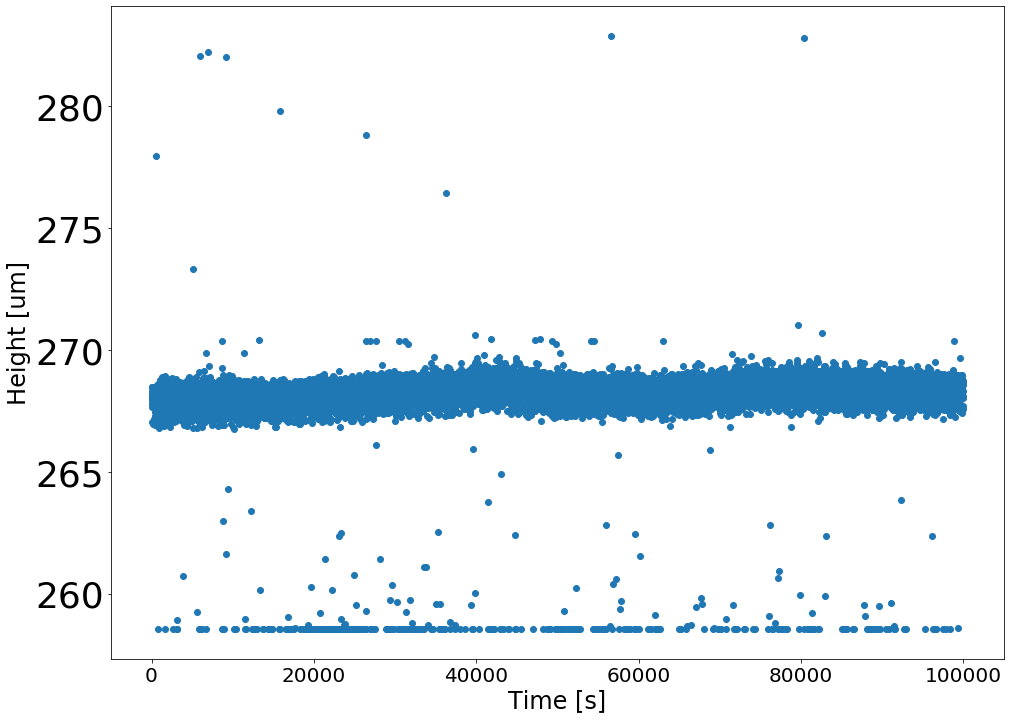

267.98280157245176 1.8715228855739345
268.31040152946804 0.5006691561154777
9630


In [73]:
plt.plot(np.arange(0,len(height)*10,10),height,linestyle="",marker="o")
plt.xlabel("Time [s]")
plt.ylabel("Height [um]")
plt.show()
print(np.mean(height),np.std(height))
print(np.mean([x for x in height if np.abs(x-np.mean(height))<(factor_std*np.std(height))]),np.std([x for x in height if np.abs(x-np.mean(height))<factor_std*np.std(height)]))
print(len([x for x in height if np.abs(x-np.mean(height))<(factor_std*np.std(height))]))

In [74]:
df['ewm_20'] = df.mean_height.ewm(span=20, adjust=False).mean() # do the exponential weighted mean over 20 files
df['ewm_100'] = df.mean_height.ewm(span=100, adjust=False).mean() # do the exponential weighted mean over 100 files
df['ewm_500'] = df.mean_height.ewm(span=500, adjust=False).mean() # do the exponential weighted mean over 100 files


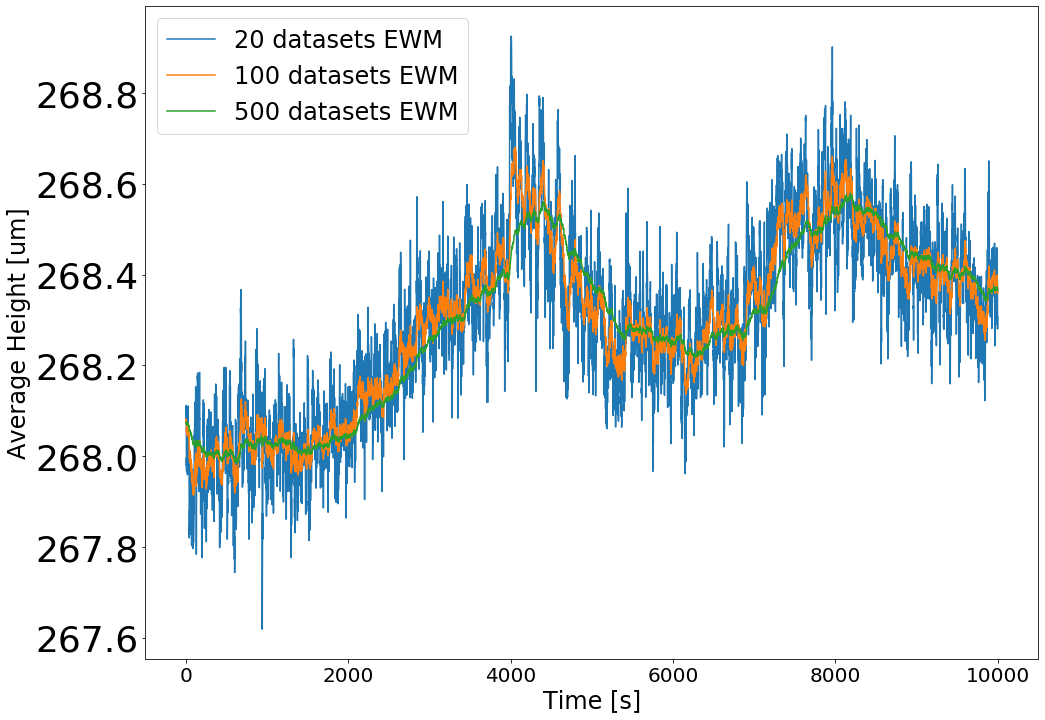

In [75]:
plt.plot(df.mean_height, label = "height-filtered data")
plt.plot(df.ewm_20, label = "20 datasets EWM")
plt.plot(df.ewm_100, label = "100 datasets EWM")
plt.xlabel("Time [s]")
plt.ylabel("Average Height [um]")
plt.legend()
plt.show()

In [76]:
# load the attractor mean position for the data file
data_filename = "/data/new_trap/" + str(bead_date) + "/Bead%s/" %bead_number +dataset
attr_pos = load_dir_reduced_to_attr_pos(dirname=data_filename,file_prefix=FOI,max_files=10000)


100%|██████████| 100/100 [09:37<00:00,  5.92s/it]


In [ ]:
# load the time frame from all the data sets in 100er chunks to not flood the memory (could be parallelized)
t = load_dir_reduced_to_time(dirname=data_filename,file_prefix=FOI,max_files=10000)



In [ ]:
df["Time_Epoch"] = t # store the time
df["Attr_Pos_V"] = attr_pos # save raw position

del t # free some memory, otherwise bunnies die
del attr_pos # free more memory


In [78]:
# save three values
## height_cal is the position of the bead in Aerotech coordinates
## z_distance transforms the cant_pos[2] voltage directly into um (using the vanilla calibration)
## z_distance_emp uses Akio's empirical data
df["height_cal"] = df['ewm_100'].apply(lambda element: element-attractor_0)
df["z_distance"] = df['height_cal'] - voltage_to_z_position(df['Attr_Pos_V'])
df["z_distance_emp"] = df['height_cal'] - voltage_to_z_position(df['Attr_Pos_V'],redo=True)


NameError: name 't' is not defined

In [ ]:
plt.plot(df.z_distance)
plt.plot(df.z_distance_emp)

In [128]:
# assume for same year and same month, it can have multiple days. get those
dt.datetime.fromtimestamp(df["Time_Epoch"][0])
year = dt.datetime.fromtimestamp(df["Time_Epoch"][0]).year
month = dt.datetime.fromtimestamp(df["Time_Epoch"][0]).month
#months = []
#months = set(months)
days = []
days = set(days)
for i in range(len(df)):
    days.add(dt.datetime.fromtimestamp(df["Time_Epoch"][i]).day)
    #months.add(dt.datetime.fromtimestamp(df["Time_Epoch"][i]).month)
print(days)

In [130]:
# prepare the files to match the time stamp to extract the environmental data
fn = []
for day in days:
    env_file = "/data/new_trap_processed/processed_files/{0}/Bead{1}/EnvData/{2}{3}{4}/environmental_data_{2}{3}{4}.pkl".format(bead_date,bead_number,year,str(month).zfill(2),str(day).zfill(2))
    fn.append(env_file)
print(fn)
    

In [131]:
df_new = match_environmental_data(df,fn) # match the environmental data

100%|██████████| 10000/10000 [02:08<00:00, 77.95it/s]


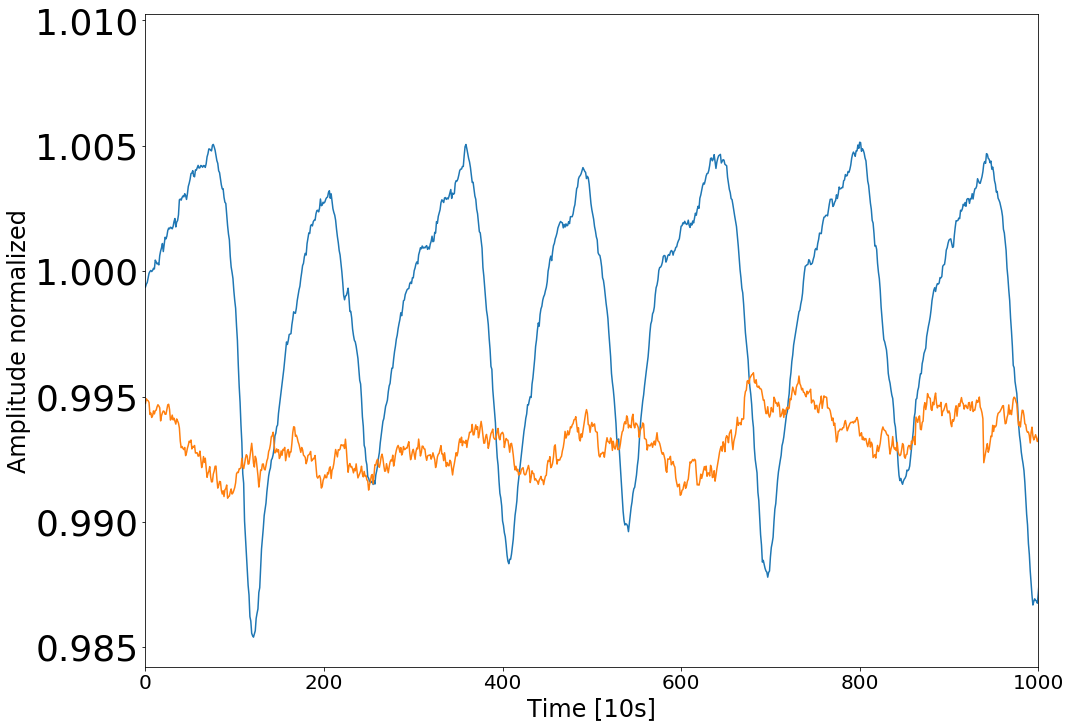

In [134]:
plt.plot(df_new.AirTemperature/df_new.AirTemperature.mean())
plt.plot(df_new.height_cal/df_new.height_cal.mean())
plt.plot(df_new.z_distance/df_new.z_distance.mean())
#plt.plot(df_new.z_distance_emp/df_new.z_distance_emp.mean())
#plt.xlim(0,1000)
plt.show()

In [49]:
# save the file
base_proc = "/data/new_trap_processed/processed_files/" + str(bead_date) +  "/Bead%s/" %bead_number

try:
    os.makedirs(base_proc+dataset)
    print("Created subdirs %s" %dataset)
except:
    print("Folder exists or you do not have permissions")
    
outputname = base_proc + dataset+FOI+"_aux.pkl"
if(os.path.isfile(outputname)==False):
    df.to_pickle(outputname)
else:print("No auxiliary file produced. %s exists already!" %outputname)    

File exists or you do not have permissions
No auxiliary file produced. /data/new_trap_processed/processed_files/20200320/Bead1/Shaking/Shaking378/Shaking3_aux.pkl exists already!


In [194]:
df = pd.read_pickle("/data/new_trap_processed/processed_files/20200320/Bead1/Shaking/Shaking378/Shaking3_aux.pkl") #here one could put the respective file name
height_cal = df["height_cal"]
z_distance = df["z_distance"]

In [195]:
print(z_distance.mean())

-15.256615328984307


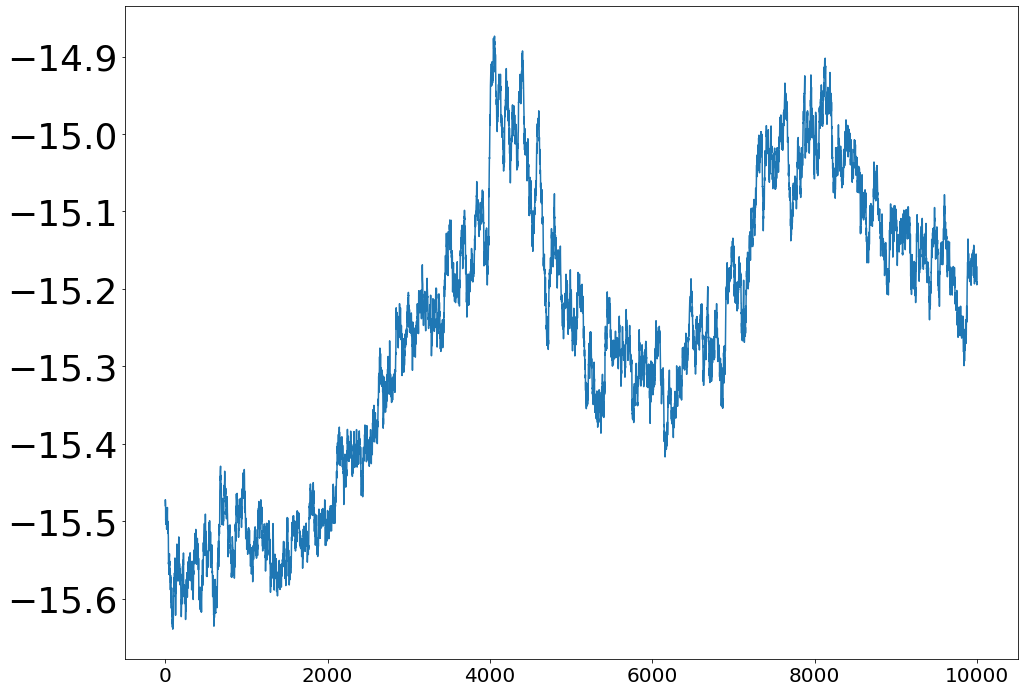

In [193]:
plt.plot(z_distance)

In [ ]:
del data # free the data